# Task

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

1. For our pipline make some experiments wiht different models: 1 - Boosting, 2 - LogisticRegression (You shouldn't forget to add in cont_transformer standartizatioт - rationing phisicals sings)
2. Сhoosing the best model by metrics/indicators
3. For the selected model (for test data) to perform an assessment of economic efficiency for the same data as in question 2 (1 dollar for attraction, 2 dollars for each true classified person)
4. (Optional) Make a selection hyperparams the best model at the end of the point 2,3
5. (Optional) One more time to perform an assessment of economic efficiency

# Additional links

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/pdf/1802.02301.pdf
4. https://arxiv.org/list/stat.ML/recent
5. https://scikit-learn.org/stable/modules/grid_search.html
6. https://scikit-learn.org/stable/modules/compose.html

# I Libraries and Functions

## 1 Import libraries

In [1]:
import os
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns

## 2 Definition of functions

In [78]:
star = lambda x:"\n" + x*50 + "\n"

def Mkdir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]

        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

def build_and_learning_model(transform, model, X_train, X_test, y_train, cv:int, scoring : str):
    model_list = [transform, model]
    M = Pipeline(model_list)
    cv_scores = cross_val_score(M, X_train, y_train, cv=cv, scoring=scoring)
    cv_score_mean = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score is {cv_score_mean}+-{cv_score_std}')
    M.fit(X_train, y_train)
    y_true_proba = M.predict_proba(X_test)[:,1]
    y_true_predict = M.predict(X_test)
    return M, y_true_proba, y_true_predict


def ROC_AUC_show(y_test, y_true):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_true, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()


def Calc_of_metrics_and_Roc_Auc(model, X_train, X_test, y_train, y_test, y_true_proba, y_true_predict):
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test, y_true_proba)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    ix = np.argmax(fscore)
    if np.isnan(fscore[ix]):
        F1 = f1_score(y_test, y_true_predict)
        closest_value = min(fscore, key=lambda x: abs(F1 - x))
        ix = list(fscore).index(closest_value)
    fpr, tpr, thresholds_ = roc_curve(y_test, y_true_proba, pos_label=1)
    print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

    print("\n","*"*50,"\n")
    ROC_AUC_show(y_test, y_true_proba)

    print("\n","*"*50,"\n")
    print(f"ROC_AUC score train: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}")
    print(f"ROC_AUC score test: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")
    metrics_dict = {"Thresholds":thresholds[ix], "F_score": fscore[ix], "Precision":precision[ix], "Recall": recall[ix]}
    return metrics_dict


def TNFP(cnf_matrix):
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    retain_sum = (FP + TP) * 1
    income = TP * 2

    tnfp = income - retain_sum
    return tnfp


# def Estimation_cost(cnf_matrix, tnfp_dict):
#     rubl_1 = (tnfp_dict["FN"] + tnfp_dict["TP"]) * rubl_late_treatment
#     print('Расходы, если не делать тест и ждать симптомов:', rubl_1)
#     print(star("*"))
#     rubl_test_all = np.sum(cnf_matrix) * rubl_test + (tnfp_dict["FN"] + tnfp_dict["TP"]) * rubl_early_treatment
#     print('Расходы, если делать тест всем и лечить группу большых:', rubl_test_all)
#     print(star("*"))
#     rubl_ML = (tnfp_dict["FP"] + tnfp_dict["TP"]) * rubl_test + tnfp_dict["FN"] * rubl_late_treatment + tnfp_dict["TP"] * rubl_early_treatment
#     print('Расходы, если использовать МЛ:', rubl_ML)
#     print(star("*"))
#     print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
#     print(star("*"))
#     print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
#     print(star("*"))
#     print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)


def business_threshold_calibrate(y_test, y_true, thresholds):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1000

    rs = []
    n = 20
    tr_list = np.linspace(0, 1, n).tolist()
    for opt_buisness_tr in tr_list:
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_true > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        retain_sum = (FP + TP) * 1
        income = TP * 2

        tnfp = retain_sum - income

        if tnfp < rubl_ML_:
            business_threshold = opt_buisness_tr

            rubl_ML_ = tnfp

        rs.append(tnfp)

    print('расходы,' if rubl_ML_ > 0 else 'прибыль,', 'если использовать БМ:', abs(rubl_ML_))
    model_value = min(tr_list, key=lambda x: abs(thresholds - x))
    model_cost = rs[tr_list.index(model_value)]
    print('расходы,' if model_cost > 0 else 'прибыль,', 'если использовать МЛ:', abs(model_cost))
    print(star("*"))

    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    busines_cost = rs[tr_list.index(business_threshold)]
    return business_threshold, busines_cost

# II Preporation Data

## 3 Load dataset

In [3]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
path_to_work_dir = "/content/drive/MyDrive/HW5_MOB/"
name_data_file = "churn_data.csv"

In [ ]:
# Mkdir(path_to_work_dir)

In [ ]:
# !wget 'https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91' -O "/content/drive/MyDrive/HW5_MOB/churn_data.csv"

In [5]:
os.listdir(path_to_work_dir)

['churn_data.csv']

In [6]:
df = pd.read_csv(path_to_work_dir + name_data_file)

## 4 Review dataset

In [7]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


### 4.1 Review target value

In [8]:
df["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [9]:
df["Exited"].value_counts(normalize=True)*100

0    79.63
1    20.37
Name: Exited, dtype: float64

## 5 Split data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, df["Exited"], random_state=42)

## 6 Definition of list features

In [11]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

## 7 Transformation of features

In [12]:
final_transformers = []

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])

    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])

    final_transformers.append((cont_col, cont_transformer))

### 7.1 Union all transformers

In [13]:
feats = FeatureUnion(final_transformers)

## 8 Build model

In [14]:
model_logreg, y_score_prob_logreg, y_score_pred_logreg = build_and_learning_model(('features', feats), ('classifier', RandomForestClassifier(random_state = 42)), X_train, X_test, y_train, 5, "roc_auc")

CV score is 0.8443898173973677+-0.010605262026785344


## 9 Calculation of metrics

Best Threshold=0.360, F-Score=0.617, Precision=0.643, Recall=0.594

 ************************************************** 



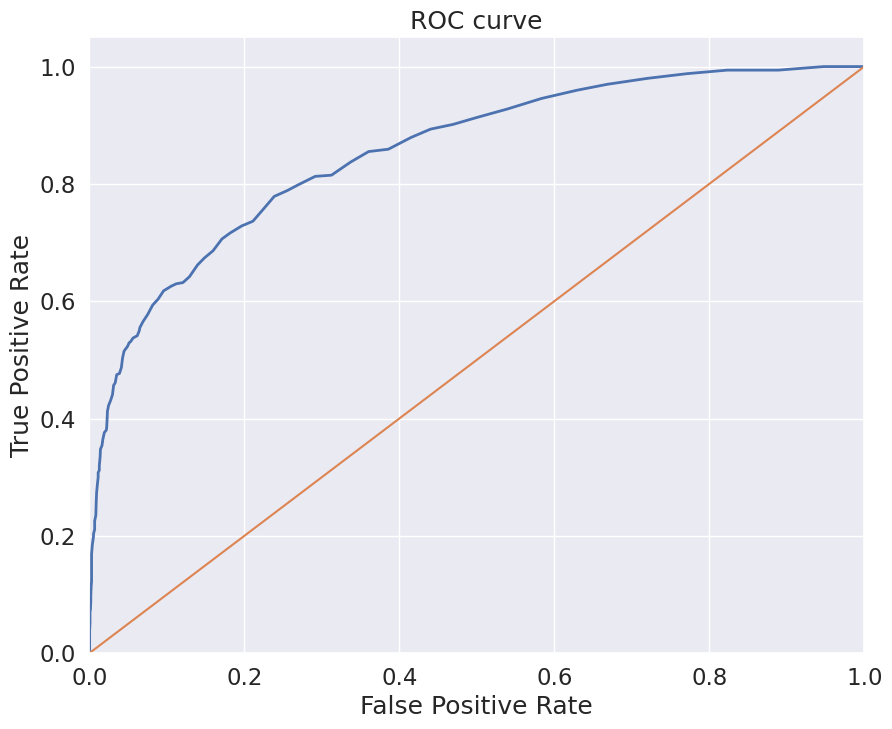


 ************************************************** 

ROC_AUC score train: 1.0
ROC_AUC score test: 0.8542005904623949


In [15]:
logreg_metrics = Calc_of_metrics_and_Roc_Auc(model_logreg, X_train, X_test, y_train, y_test, y_score_prob_logreg, y_score_pred_logreg)

## 10 Make a confusion matrix

Confusion matrix, without normalization
[[1852  151]
 [ 210  287]]


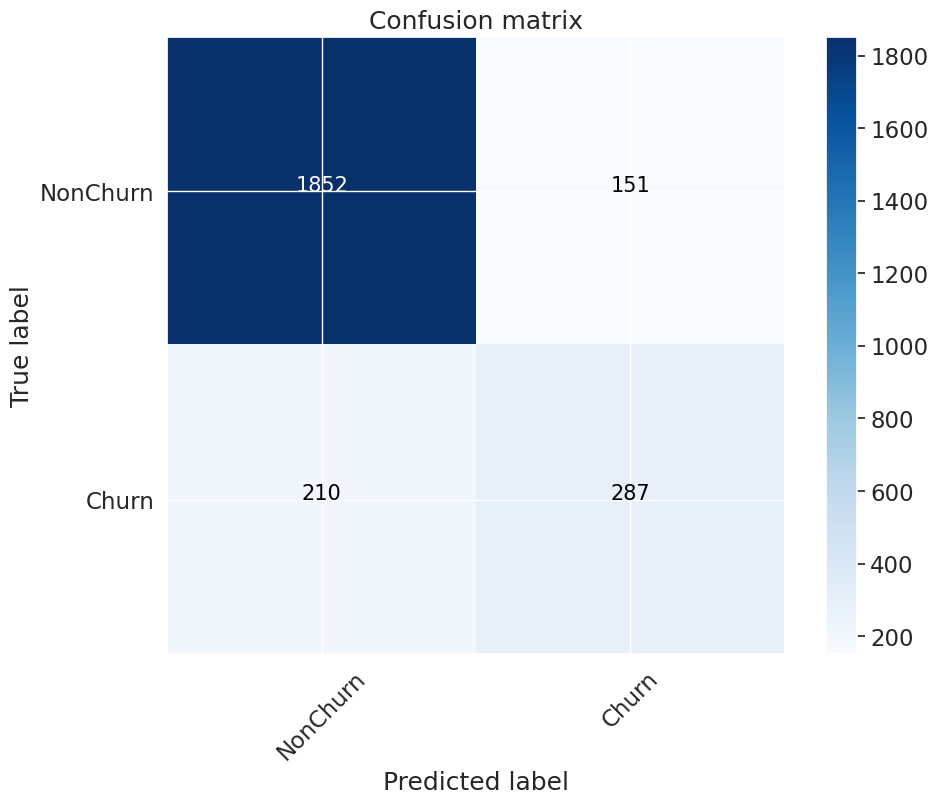

In [17]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_logreg = confusion_matrix(y_test, y_score_prob_logreg > logreg_metrics['Thresholds'])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_logreg, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## 11 Cost estimation

In [27]:
logreg_cost = TNFP(cnf_matrix_logreg)
logreg_cost

136

# III GridSearchCV Model

## 12 Selection of parameters

In [19]:
params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

In [20]:
grid = GridSearchCV(model_logreg,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.5,
 'classifier__min_samples_leaf': 3}

## 13 Build GSCV model

In [21]:
model_gscv, y_score_prob_gscv, y_score_pred_gscv = build_and_learning_model(
    ('features', feats),
    ('classifier', RandomForestClassifier(max_depth=None,
                                          max_features=0.5,
                                          min_samples_leaf=3,
                                          random_state=42)),
    X_train, X_test, y_train, 5, "roc_auc")

CV score is 0.8545092281879194+-0.007816340834985816


## 14 Calculation of metrics

Best Threshold=0.337, F-Score=0.640, Precision=0.631, Recall=0.648

 ************************************************** 



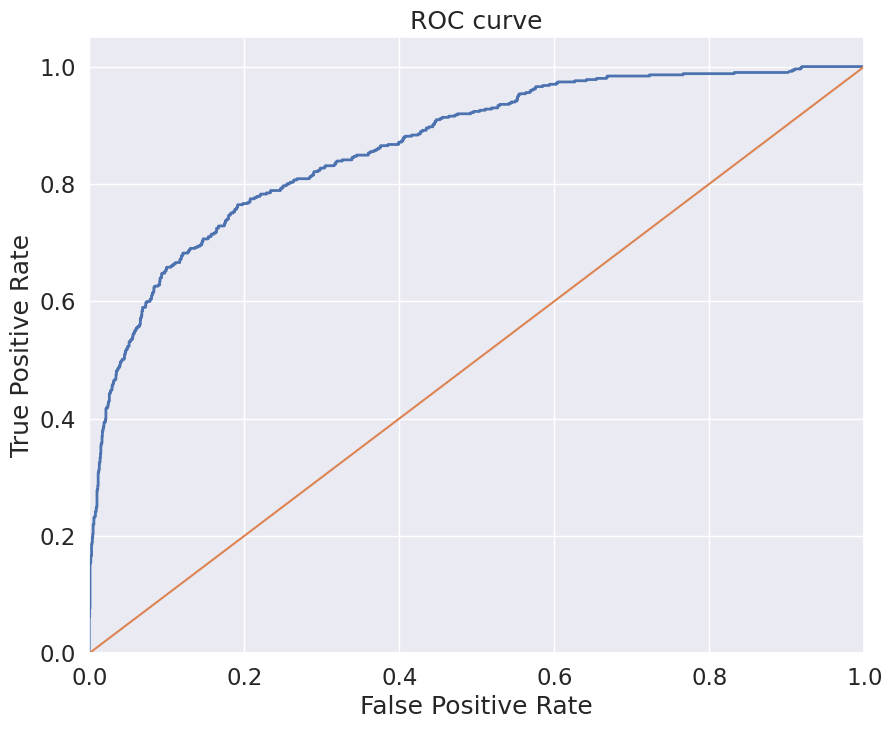


 ************************************************** 

ROC_AUC score train: 0.9915449315784887
ROC_AUC score test: 0.8645818997861356


In [22]:
gscv_metrics = Calc_of_metrics_and_Roc_Auc(model_gscv, X_train, X_test, y_train, y_test, y_score_prob_gscv, y_score_pred_gscv)

## 15 Make a confusion matrix

Confusion matrix, without normalization
[[1815  188]
 [ 176  321]]


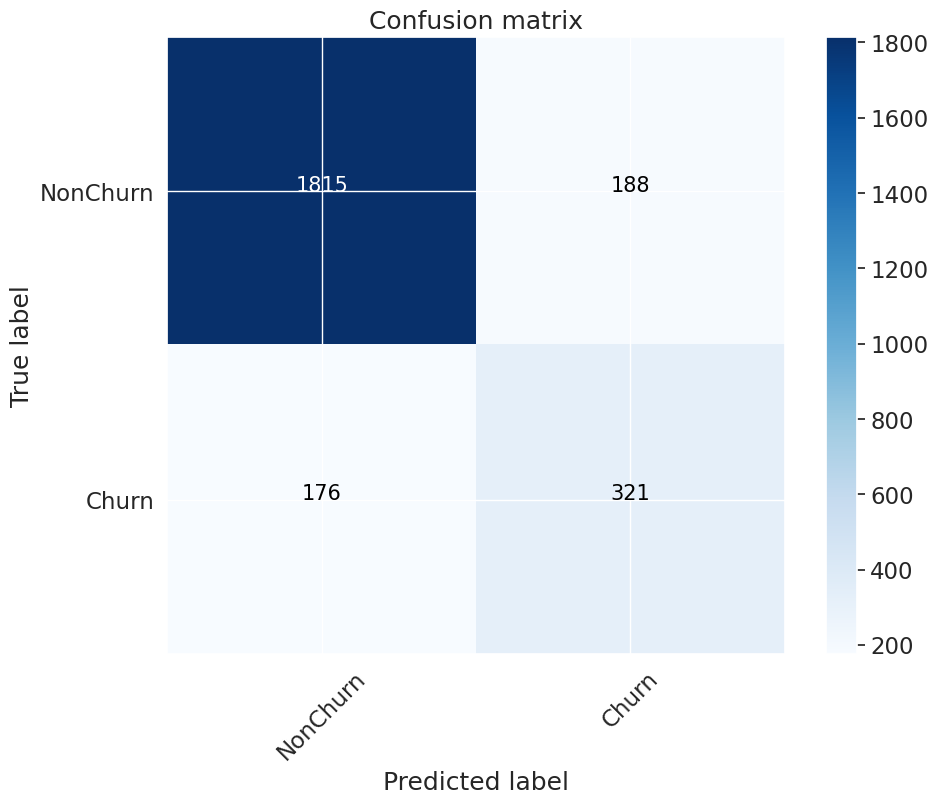

In [23]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gscv = confusion_matrix(y_test, y_score_prob_gscv > gscv_metrics['Thresholds'])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gscv, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## 16 Cost estimation

In [28]:
gscv_cost = TNFP(cnf_matrix_gscv)
gscv_cost

133

прибыль, если использовать БМ: 165
прибыль, если использовать МЛ: 114

**************************************************



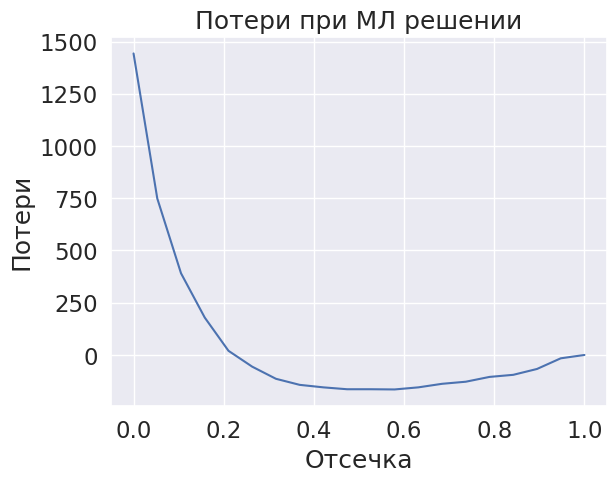


**************************************************

уровень порога по бизнес метрике 0.5789473684210527
уровень порога по f1 метрике 0.33674314574314573


In [79]:
busines_tr_gscv, cost_gscv = business_threshold_calibrate(y_test, y_score_prob_gscv,
                                          gscv_metrics['Thresholds'])

print(star("*"))
print('уровень порога по бизнес метрике', busines_tr_gscv)
print('уровень порога по f1 метрике', gscv_metrics['Thresholds'])